### Model Building 

In [19]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib


In [6]:
# Load Cleaned Data:
df = pd.read_csv('E:/Tenx/Week 3/data/cleaned_insurance_data.csv')
df.head()

C:\Users\betsi\AppData\Local\Temp\ipykernel_20196\2129816406.py:2: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('E:/Tenx/Week 3/data/cleaned_insurance_data.csv')


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


In [12]:
df_claims = df[df['TotalClaims'] > 0].copy()


# Define Features (X) and Target (y) and You can drop:    
#  Identifiers: UnderwrittenCoverID, PolicyID |  Date: TransactionMonth |     Target: TotalClaims

X = df_claims.drop(columns=[
    'TotalClaims', 
    'UnderwrittenCoverID', 
    'PolicyID', 
    'TransactionMonth'
])
y = df_claims['TotalClaims']

# Identify categorical columns:

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Convert all to string to avoid type errors
X[categorical_cols] = X[categorical_cols].astype(str)

# Apply one-hot-encoding

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Leave numerical columns unchanged
)

# Train test Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



In [13]:
# Modeling Pipeline (Random Forest Regressor)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])


In [20]:
# Fitting or training the model
model.fit(X_train, y_train)

#  Evaluate the Model

y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE on test set: {rmse:.2f}")


RMSE on test set: 36433.03


In [21]:
print(y_test.describe())

count       558.000000
mean      23263.917500
std       40138.950267
min         158.510000
25%        1447.368421
50%        6140.350877
75%       27592.453289
max      286686.431053
Name: TotalClaims, dtype: float64


In [22]:
# Save the Trained Model

import os
os.makedirs('../models', exist_ok=True)
joblib.dump(model, '../models/claim_severity_rf.joblib')


['../models/claim_severity_rf.joblib']

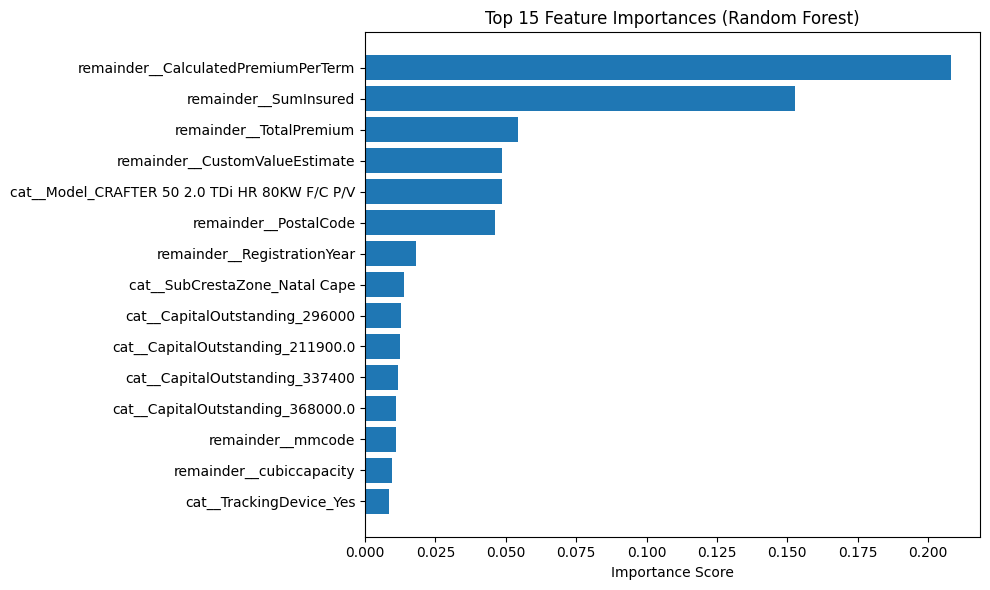

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importances from the regressor inside the pipeline
rf = model.named_steps['regressor']
feature_importance = rf.feature_importances_

# Extract feature names after preprocessing
encoded_features = model.named_steps['preprocessor'].get_feature_names_out()
importance_df = pd.DataFrame({'Feature': encoded_features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Top 15 features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()
